# Sheet 4
Jacob Waßelewsky, Johannes Schmidt, Dominik Geng
## 3 K-Nearest Neighbors: Cross-Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

load the data

In [2]:
# for faster runtimes, we use a subsampled version of the data even as the 'full' dataset
full_features = np.load('data/dijet_features_normalized.npy')[:, ::2]
full_labels = np.load('data/dijet_labels.npy')[::2]

dset_full = (full_features, full_labels) 
dset_medium = (full_features[:, ::4], full_labels[::4])
dset_small = (full_features[:, ::16], full_labels[::16])
dsets = (dset_small, dset_medium, dset_full)

for features, labels in dsets:
    print(features.shape, labels.shape)

(116, 70) (70,)
(116, 280) (280,)
(116, 1117) (1117,)


(a)

In [3]:
def crossval_splits(features, labels, n):
    """
    compute k-fold cross valditaion splits of the features and corresponding labels
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (d, N).
    labels : np.ndarray
        Label array of shape (N).
    n : int
        Number of folds.
        
    Returns
    -------
    list
        A list of the cross validation splits, i.e. a list splits of length n
        splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i)).
        
    """
    assert features.shape[-1] == len(labels), f'Shape mismatch: {features.shape}, {labels.shape}'
    
    # TODO: divide features and labels into (approximately) equal sized chunks
    chunk_size = np.floor_divide(features.shape[-1], n)
    
    # TODO: Shuffle the data
    x = features.T; y = labels ;
    c_size = np.floor_divide(x.shape[0], n) # chunk size
    p = np.random.permutation(len(x))
    x = x[p,:]; y = y[p]

    splits = [(
        ( np.concatenate([x[:i*c_size],x[(i+1)*c_size:]]), np.concatenate([y[:i*c_size],y[(i+1)*c_size:]]))  ,
        ( x[i*c_size:(i+1)*c_size], y[i*c_size:(i+1)*c_size] )
    ) for i in range(n)]

    # TODO: Construct a list consisting of the splits; each split consits of 
    #       - the validation set (one chunk of the features and corresponding labels) 
    #       - the training training set (concatenation of all feature and label chunks not used for validation)
    # i.e. splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i))
    splits = [(
        ( np.concatenate([x[:i*c_size],x[(i+1)*c_size:]]), np.concatenate([y[:i*c_size],y[(i+1)*c_size:]]))  ,
        ( x[i*c_size:(i+1)*c_size], y[i*c_size:(i+1)*c_size] ) ) for i in range(n)]
    
    assert len(splits) == n, f'Got incorrect number of splits: {len(splits)=}!={n=}'
    return splits
# could have also defined a generator to spare memory

(b)

In [4]:
def mean_err(pred, labels):
    """mean error between categorical predictions and labels (each a 1D numpy array)"""
    # TODO implement this (Hint: compute the mean over a fitting boolean array)
    err = np.mean((pred-labels) != 0) # this array has entry 1 for every unequal prediciton
    return err

In [12]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((n_folds, len(ks)))

for i, ((train_features, train_labels), (val_features, val_labels)) in enumerate(crossval_splits(full_features, full_labels, n_folds)): 
    for j, k in enumerate(ks):
        # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
        KNN = KNeighborsClassifier(k)
        KNN.fit(train_features, train_labels)
        pred = KNN.predict(val_features)
        errors[i, j] =  mean_err(pred, val_labels)

In [13]:
n_min, k_min = np.where(errors == errors.min())
print(f'The minimal error occurs for {ks[int(k_min)]} nearest neighbors.')

The minimal error occurs for 30 nearest neighbors.


In [14]:
avg_k_min = round(int(np.mean(np.argmin(errors, axis=1))))
print(f'The minimal error occurs on average for {ks[avg_k_min]} nearest neighbors.')

The minimal error occurs on average for 20 nearest neighbors.


(c)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((len(dsets), n_folds, len(ks)))

for i, (features, labels) in enumerate(dsets):
    print(f'Dataset size {len(labels)}')
    for j, ((train_features, train_labels), (val_features, val_labels)) in enumerate(crossval_splits(features, labels, n_folds)):
        for l, k in enumerate(ks):
            # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
            KNN = KNeighborsClassifier(k)
            KNN.fit(train_features, train_labels)
            pred = KNN.predict(val_features)
            errors[i, j, l] = mean_err(pred, val_labels)

Dataset size 70
Dataset size 280
Dataset size 1117


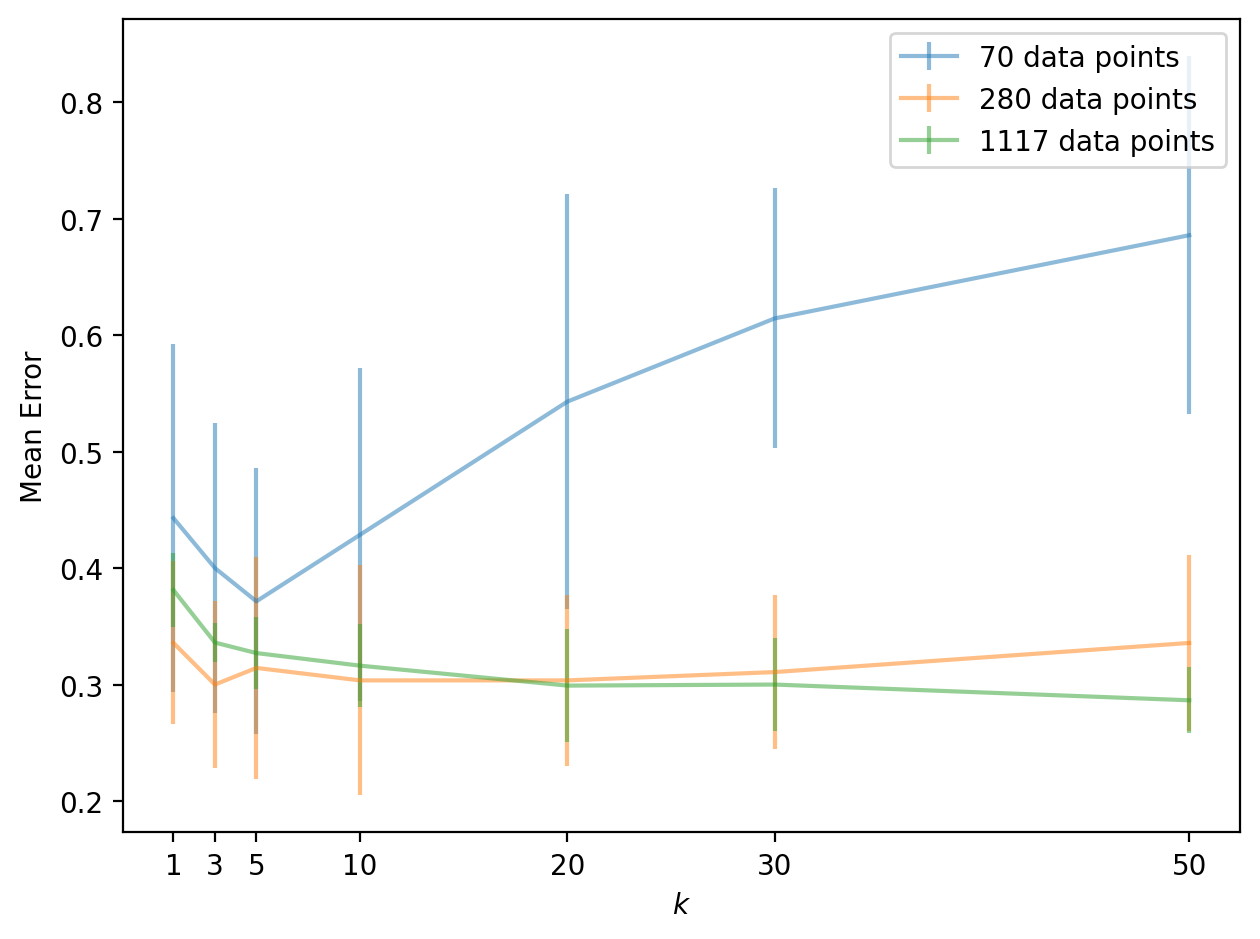

In [16]:
# TODO: make and interpret the plots as requested in the exercise
plt.figure(dpi=200)
plt.xlabel('$k$')
plt.ylabel('Mean Error')
for i in range(len(dsets)):
    plt.errorbar(ks, errors[i].mean(axis=0), yerr=errors[i].std(axis=0) , label = f'{len(dsets[i][1])} data points', alpha=0.5)
plt.legend(loc='best')
plt.xticks(ks)
plt.tight_layout();

For the smallest dataset the error grows - after a short decline - with number of nearest neighbors $k$. This is reasonable, since for a dataset size of $70$, for a $k$ of $30$ almost half of all instances are taken into account in the algorithm. This stretches the search breadth and loses the significance of more local information. <br>
For a large dataset, under the assumption that it is rather homogenously distributed, more datapoints can be taken into account. In general this leads to more accurate prediction, unless the nearest neighbor compares datapoints too far away from the query point. 